# Topic Classification using Naive Bayes

# Intro
---
In this project, I'll be working with text data from newsgroup posts covering various topics. The goal is to train classifiers that can categorize these posts based on the topics inferred from the text content. Unlike the digit classification task, where each input is a relatively **dense** 28x28 pixel matrix with many non-zero values, working with text data involves a different representation. Here, each document is represented as a "bag-of-words," which means that only a small subset of words from the entire vocabulary is active in any given document. The assumption underlying this approach is that the topic label depends solely on the count of words in the document, not their order. Throughout this project, I'll explore feature extraction techniques to effectively work with this text data. 

If you'd like to learn more about feature extraction in `sklearn`, you can refer to their documentation here:
http://scikit-learn.org/stable/modules/feature_extraction.html

In [4]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# For specifying parameter types
from typing import *

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [5]:
categories = ["alt.atheism", "talk.religion.misc", "comp.graphics", "sci.space"]
newsgroups_train = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes"), categories=categories
)
newsgroups_test = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes"), categories=categories
)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels = (
    newsgroups_test.data[num_test:],
    newsgroups_test.target[num_test:],
)
dev_data, dev_labels = (
    newsgroups_test.data[:num_test],
    newsgroups_test.target[:num_test],
)
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print("training label shape:", train_labels.shape)
print("dev label shape:", dev_labels.shape)
print("test label shape:", test_labels.shape)
print("labels names:", newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Examining the data
---

For each of the first 5 training examples, let's print the text of the message along with the label (checkout newsgroups_train.target_names).

In [6]:
def display_sample_news_posts(num_examples: int = 5) -> None:
    """
    Display a specified number of sample newsgroup posts along with their corresponding labels.

    Parameters:
    num_examples (int): The number of sample posts to display. Default is 5.

    Returns:
    None
    """

    labels = newsgroups_train.target_names
    for doc, label in zip(train_data[:num_examples], train_labels[:num_examples]):
        print(doc)
        print(f"LABEL ==> {labels[label]}")
        print("=" * 80)


display_sample_news_posts(5)

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
LABEL ==> comp.graphics


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
LABEL ==> talk.religion.misc

 >In ar

### Text representation
---

In exploring the dataset, we will start by transforming the training data into a matrix of word unigram feature vectors. This involves answering several key questions: the size of the vocabulary, the average number of non-zero features per example, the fraction of non-zero entries in the matrix, and identifying the 0th and last feature strings in alphabetical order. To achieve this, we will utilize the `CountVectorizer` along with its `fit_transform` method, nnz, shape attributes, and get_feature_names method.

Next, we'll further refine our feature vectors by restricting them to a vocabulary consisting of four specific words: ["atheism", "graphics", "space", "religion"]. We will confirm the size of this restricted vocabulary and determine the average number of non-zero features per example. For this step, we'll utilize `CountVectorizer` with a predefined vocabulary and its transform method.

We'll then explore the training data from a different perspective by transforming it into a matrix of character bigram and trigram feature vectors. Here, we'll investigate the size of the resulting vocabulary using `CountVectorizer` with customized settings.

Continuing our exploration, we'll return to word unigram feature vectors but this time prune words that appear in fewer than 10 documents. We will determine the size of this pruned vocabulary using `CountVectorizer` with a minimum document frequency (min_df) setting.

Finally, we will transform the training data into word unigram feature vectors once more and calculate the fraction of words in the development vocabulary that are missing from the training vocabulary. This step will involve building vocabularies for both the training and development datasets to make the comparison.

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [7]:
train_lower = [msg.lower() for msg in train_data]
dev_lower = [msg.lower() for msg in dev_data]


def make_unigram(data: list, vocab: list = None, mdf: int = 1) -> tuple:
    """
    Create unigram feature vectors for the given text data.

    Parameters:
    data (list or array-like): Text data to transform into unigram feature vectors.
    vocab (list or None, optional): Vocabulary to use for feature extraction. Default is None.
    mdf (int, optional): Minimum document frequency for word inclusion. Default is 1.

    Returns:
    tuple: A tuple containing the CountVectorizer object and the resulting unigram feature vectors.
    """

    vectorizer = CountVectorizer(vocabulary=vocab, min_df=mdf)
    vocab_counts = vectorizer.fit_transform(data).toarray()

    # create unigram feature vectors for all messages
    return (vectorizer, vocab_counts)


def make_ngram(data: list, vocab: list = None, mdf: int = 1) -> tuple:
    """
    Create character-based n-gram feature vectors for the given text data.

    Parameters:
    data (list or array-like): Text data to transform into n-gram feature vectors.
    vocab (list or None, optional): Vocabulary to use for feature extraction. Default is None.
    mdf (int, optional): Minimum document frequency for n-gram inclusion. Default is 1.

    Returns:
    tuple: A tuple containing the CountVectorizer object and the resulting n-gram feature vectors.
    """

    # create vectorizer using characters
    vectorizer = CountVectorizer(
        ngram_range=(2, 3), analyzer="char", vocabulary=vocab, min_df=mdf
    )
    vocab_counts = vectorizer.fit_transform(train_lower).toarray()
    # create bigram feature vectors for all messages
    return (vectorizer, vocab_counts)


def describe_data(
    train_lower: list,
    func: Callable,
    vocab: list = None,
    mdf: int = 1,
    extra_info: bool = False,
) -> None:
    """
    Generate and display descriptive statistics about text data.

    Parameters:
    train_lower (list or array-like): Text data to analyze.
    func (function): A function for feature extraction (e.g., make_unigram, make_ngram).
    vocab (list or None, optional): Vocabulary to use for feature extraction. Default is None.
    mdf (int, optional): Minimum document frequency for feature inclusion. Default is 1.
    extra_info (bool, optional): Whether to display additional information about vocabulary. Default is False.

    Returns:
    None
    """

    vectorizer, vocab_counts = func(train_lower, vocab, mdf)
    print(f"vocab size: {vocab_counts.shape[1]} grams")
    print(
        "average number of nonzero features per example:",
        np.sum(vocab_counts > 0, axis=1).mean(),
    )
    print("fraction of non-zero entries in matrix:", np.mean(vocab_counts != 0))
    alphabetical_vocab = sorted(vectorizer.get_feature_names_out())
    print(
        "zeroeth and last feature names (a-z):",
        (alphabetical_vocab[0], alphabetical_vocab[-1]),
    )
    print("=" * 70)
    if extra_info is True:
        dev_unigram = make_unigram(dev_lower, mdf=1)
        dev_word_count = len(dev_unigram[0].get_feature_names_out())
        ratio_missing = len(
            set(alphabetical_vocab) - set(dev_unigram[0].get_feature_names_out())
        ) / len(set(alphabetical_vocab))
        print(
            f"fraction of words in the development vocabulary that is missing from the training vocabulary: {ratio_missing}"
        )


def explore_text_data() -> None:
    """
    Explore the text data by computing various statistics and analyses.

    This function performs the following analyses:
    1. Unigram analysis with default settings.
    2. Unigram analysis with a predefined vocabulary.
    3. N-gram (bigram and trigram) analysis.
    4. Unigram analysis with a minimum document frequency of 10 and extra information.

    Parameters:
    None

    Returns:
    None
    """

    describe_data(train_lower, make_unigram)
    describe_data(
        train_lower, make_unigram, vocab=["atheism", "graphics", "space", "religion"]
    )
    describe_data(train_lower, make_ngram)
    describe_data(train_lower, make_unigram, mdf=10, extra_info=True)


explore_text_data()

vocab size: 26879 grams
average number of nonzero features per example: 96.70599803343165
fraction of non-zero entries in matrix: 0.0035978272269590263
zeroeth and last feature names (a-z): ('00', 'zyxel')
vocab size: 4 grams
average number of nonzero features per example: 0.26843657817109146
fraction of non-zero entries in matrix: 0.06710914454277286
zeroeth and last feature names (a-z): ('atheism', 'space')
vocab size: 35478 grams
average number of nonzero features per example: 684.1917404129794
fraction of non-zero entries in matrix: 0.01928495801378261
zeroeth and last feature names (a-z): ('\x08i', 'þ h')
vocab size: 3064 grams
average number of nonzero features per example: 72.67600786627335
fraction of non-zero entries in matrix: 0.023719323716146656
zeroeth and last feature names (a-z): ('00', 'zip')
fraction of words in the development vocabulary that is missing from the training vocabulary: 0.010117493472584857


### Initial model evaluation
---

In this model evaluation process, I will start by transforming both the training and development data into matrices of word unigram feature vectors. Next, I will create and assess multiple k-Nearest Neighbors models by varying the parameter k, including one with k set to optimize the f1 score, and for each model, I will display the k value and corresponding f1 score. Similarly, I will generate various Naive Bayes models by adjusting the smoothing parameter (alpha), with one aimed at optimizing the f1 score, and I will record the alpha value and its associated f1 score for each model. Additionally, I will build several Logistic Regression models by modifying the L2 regularization strength (C), including one optimized for the f1 score. For each Logistic Regression model, I will showcase the C value, f1 score, and sum of squared weights for each topic. During this evaluation, I will explore why k-Nearest Neighbors might not perform well for this problem, investigate the reasons behind why Logistic Regression doesn't match the performance of Naive Bayes, and analyze the relationship between the sum of squared weights in logistic regression concerning the C value.

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* Use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* Use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* Use `MultinomialNB(...)` to produce a Naive Bayes model.
* Use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* Use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* Use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [8]:
train_lower = [msg.lower() for msg in train_data]
dev_lower = [msg.lower() for msg in dev_data]


def fit_unigram(data: list, vocab: list = None, mdf: int = 1) -> CountVectorizer:
    """
    Fit a CountVectorizer to the given text data and create unigram feature vectors.

    Parameters:
    data (list or array-like): Text data to fit the vectorizer and transform into unigram feature vectors.
    vocab (list or None, optional): Vocabulary to use for feature extraction. Default is None.
    mdf (int, optional): Minimum document frequency for word inclusion. Default is 1.

    Returns:
    CountVectorizer: The fitted CountVectorizer object.
    """

    # create vectorizer
    vectorizer = CountVectorizer(vocabulary=vocab, min_df=mdf)
    vectorizer.fit(data)
    # create unigram feature vectors for all messages
    return vectorizer


def create_vectors(vectorizer: CountVectorizer, data: list) -> scipy.sparse.csr_matrix:
    """
    Transform text data into unigram feature vectors using a pre-fitted CountVectorizer.

    Parameters:
    vectorizer (CountVectorizer): A pre-fitted CountVectorizer object.
    data (list or array-like): Text data to transform into unigram feature vectors.

    Returns:
    scipy.sparse.csr_matrix: Unigram feature vectors for the input data.
    """

    return vectorizer.transform(data)


def evaluate_classification_models() -> pd.DataFrame:
    """
    Evaluate k-Nearest Neighbors, Naive Bayes, and Logistic Regression models with varying parameters.

    This function performs the following analyses:
    1. Varying k for k-Nearest Neighbors and computing f1 score.
    2. Varying alpha for Naive Bayes (MultinomialNB) and computing f1 score.
    3. Varying C for Logistic Regression and computing f1 score and sum of squared weights.

    Parameters:
    None

    Returns:
    pandas.DataFrame: A DataFrame containing the evaluation results for different models and parameters.
    """

    # storing parameters and f1 scores of all models
    knn_dict = {"(k-value, f1 score)": []}
    nb_dict = {"(alpha, f1 score)": []}
    log_dict = {"(C value, f1 score, sum of squared weights)": []}
    # value of k, alpha, and regularization strength (C) I plan to vary for each model
    values = range(1, 10, 2)
    # train unigram on train_lower
    count_vec = fit_unigram(train_lower)
    train_unigram = create_vectors(count_vec, train_lower)
    # create vocabulary to reference in dev_lower
    train_vocab = count_vec.get_feature_names_out()
    # use train_vocab to make dev unigram
    dev_unigram = create_vectors(count_vec, dev_lower)
    all_metrics = []
    for value in values:
        this_metric = {"param value (k,a,C)": value}
        # create knn models
        knn = KNeighborsClassifier(value)
        knn.fit(train_unigram, train_labels)
        predicted_knn = knn.predict(dev_unigram)
        # compute f1 score for knn
        f1_knn = metrics.f1_score(
            y_true=dev_labels, y_pred=predicted_knn, average="weighted"
        )
        this_metric["knn f1"] = f1_knn

        # create NB models
        nb = MultinomialNB(alpha=value)
        nb.fit(train_unigram, train_labels)
        predicted_nb = nb.predict(dev_unigram)
        f1_nb = metrics.f1_score(
            y_true=dev_labels, y_pred=predicted_nb, average="weighted"
        )
        # compute f1 score for nb
        this_metric["nb f1"] = f1_nb

        # create Logistic Models
        logist = LogisticRegression(C=value, solver="liblinear", multi_class="auto")
        logist.fit(train_unigram, train_labels)
        predicted_logist = logist.predict(dev_unigram)
        # f1 for logist and sum of squared weights
        f1_logist = metrics.f1_score(
            y_true=dev_labels, y_pred=predicted_logist, average="weighted"
        )
        logist_coef_sum = np.sum(logist.coef_**2)
        this_metric["logis f1"] = f1_logist
        this_metric["logis sum squared weights"] = logist_coef_sum
        all_metrics.append(this_metric)

    results = pd.DataFrame(all_metrics)

    return results


evaluate_classification_models()

,"param value (k,a,C)",knn f1,nb f1,logis f1,logis sum squared weights
0,1,0.380503,0.777732,0.696086,601.640179
1,3,0.408415,0.754084,0.691044,1158.071044
2,5,0.428761,0.723489,0.690925,1513.754503
3,7,0.450479,0.697422,0.691091,1784.052825
4,9,0.436567,0.680703,0.686478,2005.507052


* The performance disparity observed with K Nearest Neighbors (KNN) can be attributed to the choice of the Minkowski distance metric in the model. The Minkowski distance metric essentially quantifies the Euclidean distance between data points. However, in this specific context, where we are working with text data and aiming to identify topic similarities, using cosine similarity distance could be more appropriate. Cosine similarity measures the cosine of the angle between two vectors and is particularly effective for text data where the magnitude of the vectors is not as significant as their orientation. By shifting the focus of KNN towards cosine similarity, we can potentially achieve more accurate and generalized results.

* The varying performance of Logistic Regression and Naive Bayes can be understood through their underlying mechanisms and parameter tuning. As the regularization parameter C increases for Logistic Regression and alpha increases for Naive Bayes, their behavior diverges. Logistic Regression essentially attempts to determine the most accurate representation of the four categories by employing four sigmoid functions while selecting from a reduced set of feature vectors as the regularization parameter intensifies. On the other hand, Naive Bayes provides more flexibility for adjusting posterior probabilities with smaller alpha values and less flexibility with larger values. The key distinction lies in how they handle feature selection and model complexity. As C grows in Logistic Regression, it effectively reduces the number of features considered. To potentially enhance Logistic Regression's performance, normalizing the features could be a beneficial step.

* The relationship between Logistic Regression's C value and the sum of squared weights is intriguing. As the C value in Logistic Regression increases, so does the sum of squared weights. This phenomenon arises because higher C values encourage the model to retain more variables during the regularization process. Consequently, there are more squared weights associated with these variables, leading to a larger sum of squared weights. Essentially, the model becomes less constrained, allowing it to incorporate more features into the decision-making process. Understanding this relationship is essential for fine-tuning the Logistic Regression model, as it helps control the trade-off between model complexity and regularization.

### Feature exploration
---
To explore features, I will follow these steps:

1. **Feature Extraction**: Begin by transforming the text data into a matrix of word bigram feature vectors. This matrix will serve as the foundation for subsequent analysis. For this task, I intend to utilize a Logistic Regression model.

1. **Feature Weight Analysis**: Next, I will focus on understanding the significance of these features within each topic. For each topic, I will identify the 5 features with the largest weights, considering the raw weights (not absolute values). If there are no feature overlaps among topics, this step will yield a total of 20 distinctive features.

1. **Weight Visualization**: To gain deeper insights, I will create a structured table to visualize these feature weights. This table will consist of 20 rows, representing the features (words) identified, and 4 columns, each corresponding to one of the topics. Each cell in this table will display the weight of a particular feature for all topics.

1. **Analyzing Surprising Features**: Finally, I will engage in an exploratory analysis by examining this feature-weight table. The goal is to identify any unexpected or intriguing patterns among these features. This step involves qualitative assessment and hypothesis generation based on the feature weights' distribution across topics.

Notes:
* Train on the transformed training data.
* Use `CountVectorizer` and its `.fit_transform` method to transform data.
* Use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* Use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* Use `np.argsort` to get indices sorted by element value. 



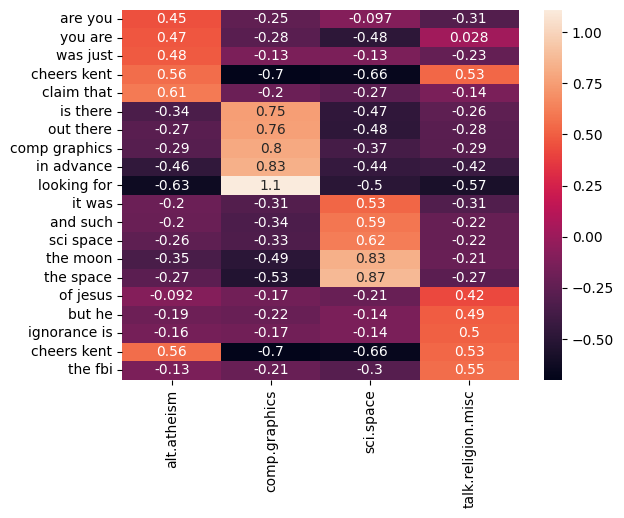

In [9]:
train_lower = [msg.lower() for msg in train_data]
dev_lower = [msg.lower() for msg in dev_data]


def make_bigram(data: list, vocab: list = None, mdf: int = 1) -> tuple:
    """
    Create word bigram feature vectors for the given text data.

    Parameters:
    data (list or array-like): Text data to transform into word bigram feature vectors.
    vocab (list or None, optional): Vocabulary to use for feature extraction. Default is None.
    mdf (int, optional): Minimum document frequency for bigram inclusion. Default is 1.

    Returns:
    tuple: A tuple containing the CountVectorizer object and the resulting word bigram feature vectors.
    """

    # create vectorizer using characters
    vectorizer = CountVectorizer(
        ngram_range=(2, 2), analyzer="word", vocabulary=vocab, min_df=mdf
    )
    vocab_counts = vectorizer.fit_transform(data).toarray()
    # create bigram feature vectors for all messages
    return (vectorizer, vocab_counts)


def analyze_bigram_weights() -> None:
    """
    Analyze the word bigram weights for Logistic Regression models.

    This function performs the following steps:
    1. Transforms the training and development data into word bigram feature vectors.
    2. Fits a Logistic Regression model with predefined parameters.
    3. Extracts the top 5 features with the largest weights for each topic.
    4. Creates a heatmap to visualize the weights of these features for each topic.

    Parameters:
    None

    Returns:
    None
    """

    train_bigram = make_bigram(train_lower)[1]
    # create vocabulary to reference in dev_lower
    train_vocab = make_bigram(train_lower)[0].get_feature_names_out()
    # use train_vocab to make dev unigram
    dev_bigram = make_bigram(dev_lower, vocab=train_vocab)[1]
    # produce logistic regression model
    logist_mod = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    logist_mod.fit(train_bigram, train_labels)
    mod_coefs = logist_mod.coef_
    col_names = ["alt.atheism", "comp.graphics", "sci.space", "talk.religion.misc"]
    a = np.argsort(mod_coefs, axis=1)[:, -5:].ravel()

    word_weight = pd.DataFrame(a, columns=["word index"])
    for i, name in enumerate(col_names):
        word_weight[name] = mod_coefs[i][word_weight["word index"]]
    word_weight
    word_weight["word"] = np.array(train_vocab)[word_weight["word index"]]
    word_weight
    sns.heatmap(
        word_weight[col_names],
        yticklabels=word_weight["word"],
        xticklabels=col_names,
        annot=True,
    )
    plt.xticks(rotation=90)


analyze_bigram_weights()

In the table and in the heatmap I made, I noticed one surprising feature, the bigram "cheers kent" was weighted heavily in both the religion and atheism labels. I was trying to think of why this may be... potentially someone who promotes atheism talking about religion simulataneously or vice versa?

### Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, I could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Todo:
1. Produce a Logistic Regression model (with no preprocessing of text). **I may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary. I will aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after I applied pre-processing.
* Evaluate on the transformed development data. Note that I never want to "learn" anything from the dev data.
* Use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* Use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* Use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [10]:
train_lower = [msg.lower() for msg in train_data]
dev_lower = [msg.lower() for msg in dev_data]


def make_unigram_pro(
    data: list,
    vocab: list = None,
    mdf: int = 1,
    stop: list = None,
    strip: str = None,
    lc: bool = False,
) -> tuple:
    """
    Create a unigram CountVectorizer with optional text processing settings.

    Parameters:
    data (list or array-like): Text data to transform into unigram feature vectors.
    vocab (list or None, optional): Vocabulary to use for feature extraction. Default is None.
    mdf (int, optional): Minimum document frequency for word inclusion. Default is 1.
    stop (list or None, optional): List of stop words to exclude from the vocabulary. Default is None.
    strip (str or None, optional): Whether to strip accents during preprocessing. Default is None.
    lc (bool, optional): Whether to convert text to lowercase. Default is False.

    Returns:
    tuple: A tuple containing the CountVectorizer object and the resulting unigram feature vectors.
    """

    # create vectorizer
    vectorizer = CountVectorizer(
        vocabulary=vocab, min_df=mdf, stop_words=stop, strip_accents=strip, lowercase=lc
    )
    vocab_counts = vectorizer.fit_transform(data).toarray()

    # create unigram feature vectors for all messages
    return (vectorizer, vocab_counts)


def compare_unigram_processing() -> None:
    """
    Compare the performance of Logistic Regression models with and without text processing.

    This function trains Logistic Regression models on unigram feature vectors with and without text processing.
    It prints and compares the F1 scores and vocabulary sizes for both models.

    Parameters:
    None

    Returns:
    None
    """

    # with no processing of text

    train_unigram = make_unigram(train_data)[1]
    # create vocabulary to reference in dev_lower
    train_vocab = make_unigram(train_data)[0].get_feature_names_out()
    # use train_vocab to make dev unigram
    dev_unigram = make_unigram(dev_data, vocab=train_vocab)[1]

    log_reg = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    log_reg.fit(train_unigram, train_labels)
    predicted_logist = log_reg.predict(dev_unigram)
    f1_logist = metrics.f1_score(
        y_true=dev_labels, y_pred=predicted_logist, average="weighted"
    )

    # with processing of text

    train_unigram_pro = make_unigram_pro(
        train_lower, stop="english", strip="unicode", lc=True
    )[1]
    # create vocabulary to reference in dev_lower
    train_vocab_pro = make_unigram_pro(
        train_lower, stop="english", strip="unicode", lc=True
    )[0].get_feature_names_out()
    # use train_vocab to make dev unigram
    dev_unigram_pro = make_unigram_pro(
        dev_lower, vocab=train_vocab_pro, stop="english", strip="unicode", lc=True
    )[1]

    log_reg_pro = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    log_reg_pro.fit(train_unigram_pro, train_labels)
    predicted_logist_pro = log_reg_pro.predict(dev_unigram_pro)
    f1_logist_pro = metrics.f1_score(
        y_true=dev_labels, y_pred=predicted_logist_pro, average="weighted"
    )
    print(
        f"f1 score no processing: {f1_logist}, vocab size no processing {len(train_vocab)}"
    )
    print(
        f"f1 score w processing: {f1_logist_pro}, vocab size w processing {len(train_vocab_pro)}"
    )
    print(f"f1 score improvement: {f1_logist_pro - f1_logist}")


compare_unigram_processing()

f1 score no processing: 0.7084739776490449, vocab size no processing 26879
f1 score w processing: 0.7237415476450151, vocab size w processing 26576
f1 score improvement: 0.015267569995970232


### L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths:
* Train a Logistic Regression model using L1 regularization.
* Reduce the vocabulary to only those features with at least one non-zero weight among the four categories.
* Train a new Logistic Regression model using the reduced vocabulary and L2 regularization strength set to 0.5.
* Evaluate and record the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

1. Create a plot of f1 score vs. the logarithm of vocabulary size. Each point on the plot corresponds to a specific L1 regularization strength used to reduce the vocabulary.

1. Analyze and compare the performance of models based on reduced vocabularies with that of a model based on the full vocabulary.

Notes:
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* Use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* Use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* Use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

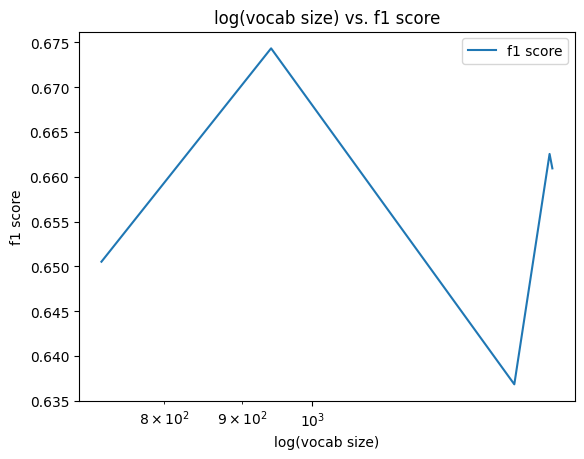

In [11]:
train_lower = [msg.lower() for msg in train_data]
dev_lower = [msg.lower() for msg in dev_data]
strengths = [1, 2, 3, 4, 5]


def l1_prune_vocab(dev_lower: list, strength: float) -> np.ndarray:
    """
    Reduce the vocabulary based on L1 regularization strength and return important words.

    Parameters:
    dev_lower (list or array-like): Text data to analyze.
    strength (float): The L1 regularization strength used to prune the vocabulary.

    Returns:
    important_words (numpy.ndarray): An array of important words determined by the L1 regularization.
    """

    train_unigram = make_unigram(train_lower)[1]
    # create vocabulary to reference in dev_lower
    train_vocab = make_unigram(train_lower)[0].get_feature_names_out()
    # use train_vocab to make dev unigram
    dev_unigram = make_unigram(dev_lower, vocab=train_vocab)[1]
    # for s in strengths:
    logist_mod = LogisticRegression(
        C=strength, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015
    )
    logist_mod.fit(train_unigram, train_labels)
    mod_coefs = logist_mod.coef_

    col_names = ["alt.atheism", "comp.graphics", "sci.space", "talk.religion.misc"]

    important_indexes = np.where(mod_coefs.sum(axis=0) > 0)[0]
    important_words = np.array(train_vocab)[important_indexes]
    return important_words


def l2_reg(
    important_words: list, dev_lower: list, reg_strength: float, dev_labels: np.ndarray
) -> dict:
    """
    Evaluate a Logistic Regression model with L2 regularization using a reduced vocabulary.

    This function trains a Logistic Regression model with L2 (ridge) regularization on the given
    reduced vocabulary and evaluates its performance using the provided development data and labels.

    Parameters:
    important_words (list): List of important words/features from the reduced vocabulary.
    dev_lower (list): Text data for development (lowercased).
    reg_strength (float): L2 regularization strength (C) for Logistic Regression.
    dev_labels (array-like): True labels for the development data.

    Returns:
    dict: A dictionary containing the regularization strength, vocabulary size, and weighted F1 score.
    """

    train_unigram = make_unigram(train_lower, vocab=important_words)[1]
    dev_unigram = make_unigram(dev_lower, vocab=important_words)[1]
    logist_mod = LogisticRegression(
        C=0.5, solver="liblinear", multi_class="auto", penalty="l2", tol=0.015
    )
    logist_mod.fit(train_unigram, train_labels)
    predicted_logist_pro = logist_mod.predict(dev_unigram)
    f1_score = metrics.f1_score(
        y_true=dev_labels, y_pred=predicted_logist_pro, average="weighted"
    )
    return {
        "reg strength": reg_strength,
        "vocab size": len(important_words),
        "f1 score": f1_score,
    }


def evaluate_regularization_strengths(dev_lower, dev_labels):
    """
    Evaluate Logistic Regression models with different regularization strengths.

    This function evaluates Logistic Regression models with various L2 regularization strengths
    on a reduced vocabulary obtained by applying L1 regularization. It returns a DataFrame
    containing regularization strengths, vocabulary sizes, and weighted F1 scores for each model.

    Parameters:
    dev_lower (list): Text data for development (lowercased).
    dev_labels (array-like): True labels for the development data.

    Returns:
    pd.DataFrame: A DataFrame with columns for regularization strength, vocabulary size, and F1 score.
    """

    np.random.seed(0)
    strengths = range(1, 6)
    all_results = []
    for s in strengths:
        important_words = l1_prune_vocab(dev_lower, s)
        results = l2_reg(important_words, dev_lower, s, dev_labels)
        all_results.append(results)
    return pd.DataFrame(all_results)


df = evaluate_regularization_strengths(dev_lower, dev_labels)

line_plot = df.plot(
    x="vocab size",
    y="f1 score",
    kind="line",
    logx=True,
    xlabel="log(vocab size)",
    ylabel="f1 score",
    title="log(vocab size) vs. f1 score",
)

Utilizing reduced vocabularies in models consistently yields superior F1 scores compared to their counterparts with larger, less focused vocabularies. Beyond a certain threshold, the F1 score exhibits a discernible decline as vocabulary size expands. This trend is vividly illustrated in the logarithmic graph depicting the relationship between log-transformed vocabulary size and F1 score, underscoring the significance of vocabulary curation in enhancing model performance.

### TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [15]:
def make_tfidf(data: list) -> TfidfVectorizer:
    """
    Create a TF-IDF vectorizer and fit it to the training data.

    Parameters:
    data (list): A list of text data (e.g., messages).

    Returns:
    TfidfVectorizer: A trained TF-IDF vectorizer.
    """
    vectorizer = TfidfVectorizer()
    vectorizer.fit(data)
    return vectorizer


def make_vectors(vectorizer: TfidfVectorizer, data: list) -> scipy.sparse.csr_matrix:
    """
    Transform text data into TF-IDF feature vectors using a pre-trained vectorizer.

    Parameters:
    vectorizer (TfidfVectorizer): A pre-trained TF-IDF vectorizer.
    data (list): A list of text data to be transformed.

    Returns:
    scipy.sparse.csr_matrix: TF-IDF feature vectors for the input data.
    """
    return vectorizer.transform(data)


def calc_r(predicted_proba_dev: np.ndarray, dev_labels: np.ndarray) -> np.ndarray:
    """
    Calculate R ratios for predicted probabilities and true labels.

    Parameters:
    predicted_proba_dev (numpy.ndarray): Predicted class probabilities for the development data.
    dev_labels (numpy.ndarray): True labels for the development data.

    Returns:
    numpy.ndarray: R ratios for each instance in the development data.
    """
    max_proba = predicted_proba_dev.max(axis=1)
    proba_true_label = np.array(
        [probas[i] for probas, i in zip(predicted_proba_dev, dev_labels)]
    )
    r_ratios = max_proba = proba_true_label
    return r_ratios


def train_and_predict_logistic_regression(
    train_data: list,
    train_labels: np.ndarray,
    dev_data: list,
    dev_lower: list,
    dev_labels: np.ndarray,
) -> None:
    """
    Train a logistic regression classifier, predict labels for the development data, and print the top 3 documents with the highest R ratios.

    Parameters:
    train_data (list): Training data (e.g., messages) for fitting a TF-IDF vectorizer.
    train_labels (numpy.ndarray): True labels for the training data.
    dev_data (list): Development data (e.g., messages) for prediction.
    dev_lower (list): Preprocessed development data (e.g., lowercase text).
    dev_labels (numpy.ndarray): True labels for the development data.

    Returns:
    None
    """
    fitted_tfidf = make_tfidf(train_data)
    train_vectors = make_vectors(fitted_tfidf, train_data)
    # create vocabulary to reference in dev_lower
    train_vocab = fitted_tfidf.get_feature_names_out()
    # use train_vocab to make dev unigram
    dev_vectors = make_vectors(fitted_tfidf, dev_lower)
    # make logistic model
    log_reg = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    log_reg.fit(train_vectors, train_labels)
    predicted_dev_log_reg = log_reg.predict(dev_vectors)
    predicted_proba_dev = log_reg.predict_proba(dev_vectors)
    r_ratios = calc_r(predicted_proba_dev, dev_labels)

    # Sort documents by R ratios in descending order
    sorted_documents = [
        (dev_data[idx], r_ratio) for idx, r_ratio in enumerate(r_ratios)
    ]
    sorted_documents.sort(key=lambda x: x[1], reverse=True)

    # Print the top 3 documents
    for i, (document, r_ratio) in enumerate(sorted_documents[:3], start=1):
        print(f"Top {i} Document (R Ratio: {r_ratio}):")
        print(document)
        print("#!@" * 33)


# Call the function to print the top 3 documents
train_and_predict_logistic_regression(
    train_data, train_labels, dev_data, dev_lower, dev_labels
)

Top 1 Document (R Ratio: 0.999978716382369):
Archive-name: graphics/faq

This message is automatically posted once a week or so in an effort to
cut down on the repetitive junk in comp.graphics.  It was last changed
on 26Apr93.  If you have answers to other frequently asked questions that
you would like included in this posting, please send me mail.  If you
don't want to see this posting every week, please add the subject line
to your kill file.  Thank you.

If your copy of the FAQ is more than a couple of weeks old, you may want to
seek out the most recent version.  The latest version of this FAQ is always
available on the archive site pit-manager.mit.edu (alias rtfm.mit.edu) as
pub/usenet/news.answers/graphics/faq.

---
_john

	John Grieggs grieggs@jpl-devvax.jpl.nasa.gov JohnG@portal.com
---
Last update: 26Apr93

Sorry I haven't posted this for a couple of weeks, but I was called out of
town due to a death in the family.  This is reality, folks.

What's new?

SIGGRAPH Online Bibliogr

TfIdf talks about the ratio of term frequency to document frequency where Count Vectorizer just talks about term frequency. This ratio in TfIdf allows for relative weighting of the terms relative to how much they show up in the entire document. In order to improve the results of my model, I would need to find a way to make sure that not only the longest documents had the highest R scores. The longer a document, the more words will show up and so the larger the numerator of the R score will be and therefore the larger the R value. To accomplish this, I can chop the length of all of my documents to be under a certain value. 

### Produce a Logistic Regression model to implement your suggestion from the previous section
---


In [11]:
stay_under_len_of_percentile = 0.75
doc_lens = [len(msg) for msg in train_lower]
cutoff = sorted(doc_lens)[int(stay_under_len_of_percentile * len(train_lower))]
chopped_train = [msg[:cutoff] for msg in train_lower]
chopped_dev = [msg[:cutoff] for msg in dev_lower]


fitted_tfidf = make_tfidf(chopped_train)
train_vectors = make_vectors(fitted_tfidf, chopped_train)
# create vocabulary to reference in dev_lower
train_vocab = fitted_tfidf.get_feature_names()
# use train_vocab to make dev unigram
dev_vectors = make_vectors(fitted_tfidf, chopped_dev)
# make logistic model

log_reg = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
log_reg.fit(train_vectors, train_labels)
predicted_dev_log_reg = log_reg.predict(dev_vectors)
predicted_proba_dev = log_reg.predict_proba(dev_vectors)
top_3_r_ratios = np.argsort(calc_r(predicted_proba_dev, dev_labels), axis=0)[:-4:-1]

for idx in top_3_r_ratios:
    print(dev_data[idx])
    # documents seperated by lines of "#!@"
    print("#!@" * 33)

Hi.  I'm looking for a 3D shark for use in a ray tracing rountine I'm doing.
 I'll be using Vivid or POV, but it can be in any format.  Are there any
 FTP sites with 3D objects or does anyone have a good 3D shark?

Thanks alot!

Chad


#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@
)Many high-end graphics cards come with C source code for doing basic graphics
)sorts of things (change colors, draw points/lines/polygons/fills, etc.).  Does
)such a library exist for generic VGA graphics cards/chips, hopefully in the
)public domain?  This would be for the purpose of compiling under a non-DOS
)operating system running on a standard PC.

Check the server code for X11R5.  (or "XFree86")
#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@#!@

I'm also interested in info both public domain and commercial graphics library 
package to do PC VGA graphics.  

I'm currently working on a realtime applica

Here, we can tell that the length of the articles are much shoerter once I create my 0.75 cutoff value for the length of the document. The top 3 R-ratio valued articles after this filtering are much shorter but still contain heavy repetitions of words like "3D", "graphics", "server", and "library"

## Summary
---
In this project, I worked with newsgroup text data to categorize posts by topics, employing various models like k-Nearest Neighbors, Naive Bayes, and Logistic Regression, optimizing them for f1 scores. Notably, the choice of Minkowski distance in k-Nearest Neighbors affected its performance, suggesting the use of cosine similarity for text data. Logistic Regression's behavior was tied to the regularization parameter, impacting feature selection. Smaller, focused vocabularies consistently improved F1 scores, and vocabulary size showed a non-linear relationship with performance. Additionally, Tf-Idf and Count Vectorizer were compared, highlighting their differences. Addressing document length bias was proposed, showing promising results in mitigating length-based effects. These findings offer valuable insights for text data classification and model optimization. Through this project, I learned the importance of feature selection, model parameter tuning, and the need to account for inherent biases in text data to build robust classifiers.